In [1]:
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas_datareader import DataReader

import pyflux as pf
import pmdarima as pm

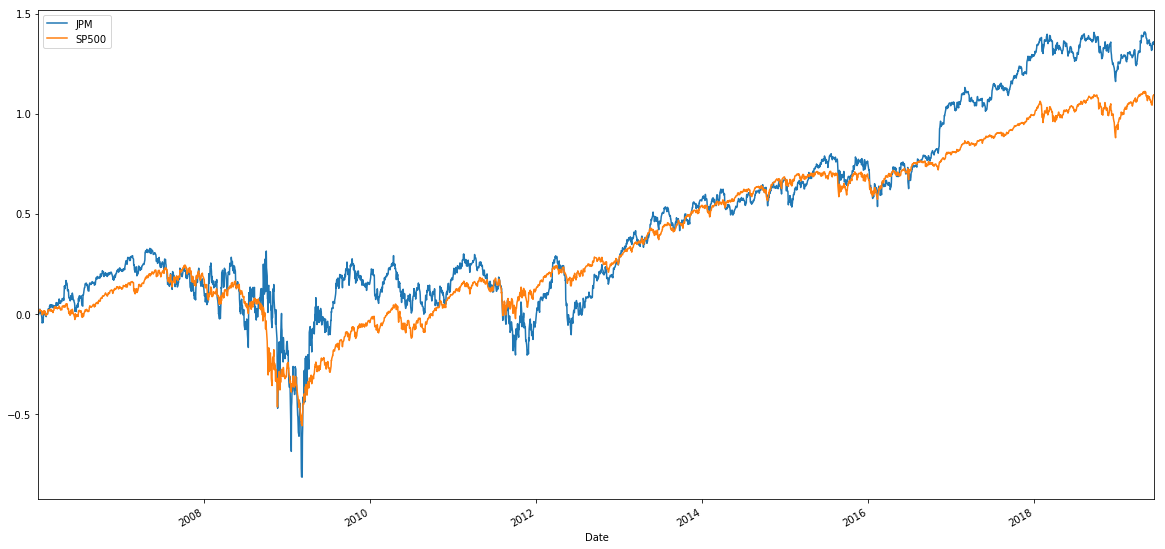

In [2]:
start = dt.datetime(2006, 1, 1)
end = dt.datetime(2019, 6, 13)

jpm = DataReader('JPM', 'yahoo', start, end)
jpm['log_returns'] = np.log(jpm['Adj Close']).diff(1)

sp500 = DataReader('SPY', 'yahoo', start, end)
sp500['log_returns'] = np.log(sp500['Adj Close']).diff(1)

data = pd.merge(jpm['log_returns'], sp500['log_returns'], left_index=True, right_index=True).dropna()
data.columns = ['JPM', 'SP500']

data.cumsum().plot(figsize=(20, 10))

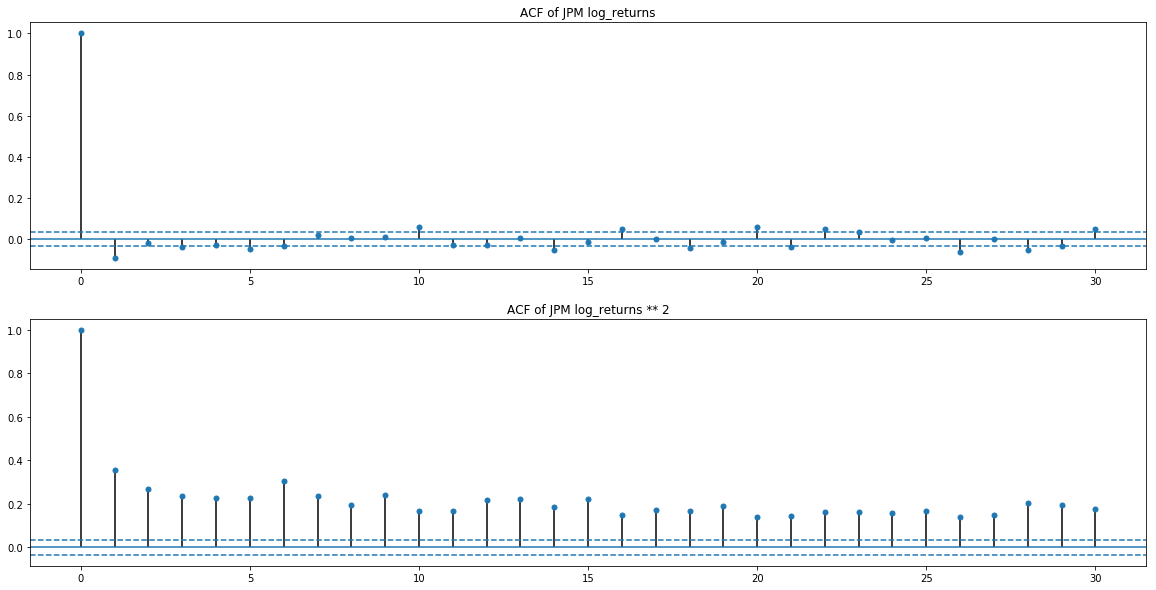

In [3]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2)

ax[0].axhline(2 / np.sqrt(len(data)), linestyle='--')
ax[0].axhline(-2 / np.sqrt(len(data)), linestyle='--')
pm.plot_acf(data['JPM'], ax=ax[0], show=False, title='ACF of JPM log_returns', lags=30)

ax[1].axhline(2 / np.sqrt(len(data)), linestyle='--')
ax[1].axhline(-2 / np.sqrt(len(data)), linestyle='--')
pm.plot_acf(data['JPM'] ** 2, ax=ax[1], show=False, title='ACF of JPM log_returns ** 2', lags=30)

plt.show()

Squared returns demonstrate strong autocorrelation. The fact that autocorrelation persists and decays over several lags is evidence of an autoregressive effect within volatility.

Volatility can be model using GARCH:

$$
    y_{t} \text{ ~ } \mathcal{N}(\mu, \sigma_{t})
$$

$$
    \sigma_{t}^{2} = \omega + \alpha\epsilon_{t}^{2} + \beta\sigma_{t-1}^{2}
$$

In [4]:
model = pf.GARCH(p=1, q=1, data=data[['JPM']])
print(model.latent_variables)

Index    Latent Variable           Prior           Prior Hyperparameters     V.I. Dist  Transform 
======== ========================= =============== ========================= ========== ==========
0        Vol Constant              Normal          mu0: 0, sigma0: 3         Normal     exp       
1        q(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
2        p(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
3        Returns Constant          Normal          mu0: 0, sigma0: 3         Normal     None      


In [5]:
# Using Truncated Normal priors for alpha and beta
model.adjust_prior(1, pf.TruncatedNormal(0.01, 0.5, lower=0.0, upper=1.0))
model.adjust_prior(1, pf.TruncatedNormal(0.97, 0.5, lower=0.0, upper=1.0))

In [6]:
# Perform inference using Metropolis-Hastings algorithm
fit = model.fit('M-H', nsims=int(2e4))

Acceptance rate of Metropolis-Hastings is 0.00025
Acceptance rate of Metropolis-Hastings is 0.025425
Acceptance rate of Metropolis-Hastings is 0.3214

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.3227375


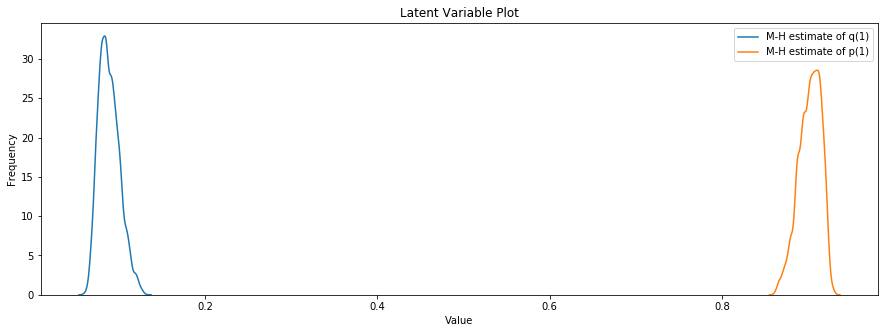

In [7]:
model.plot_z([1, 2])

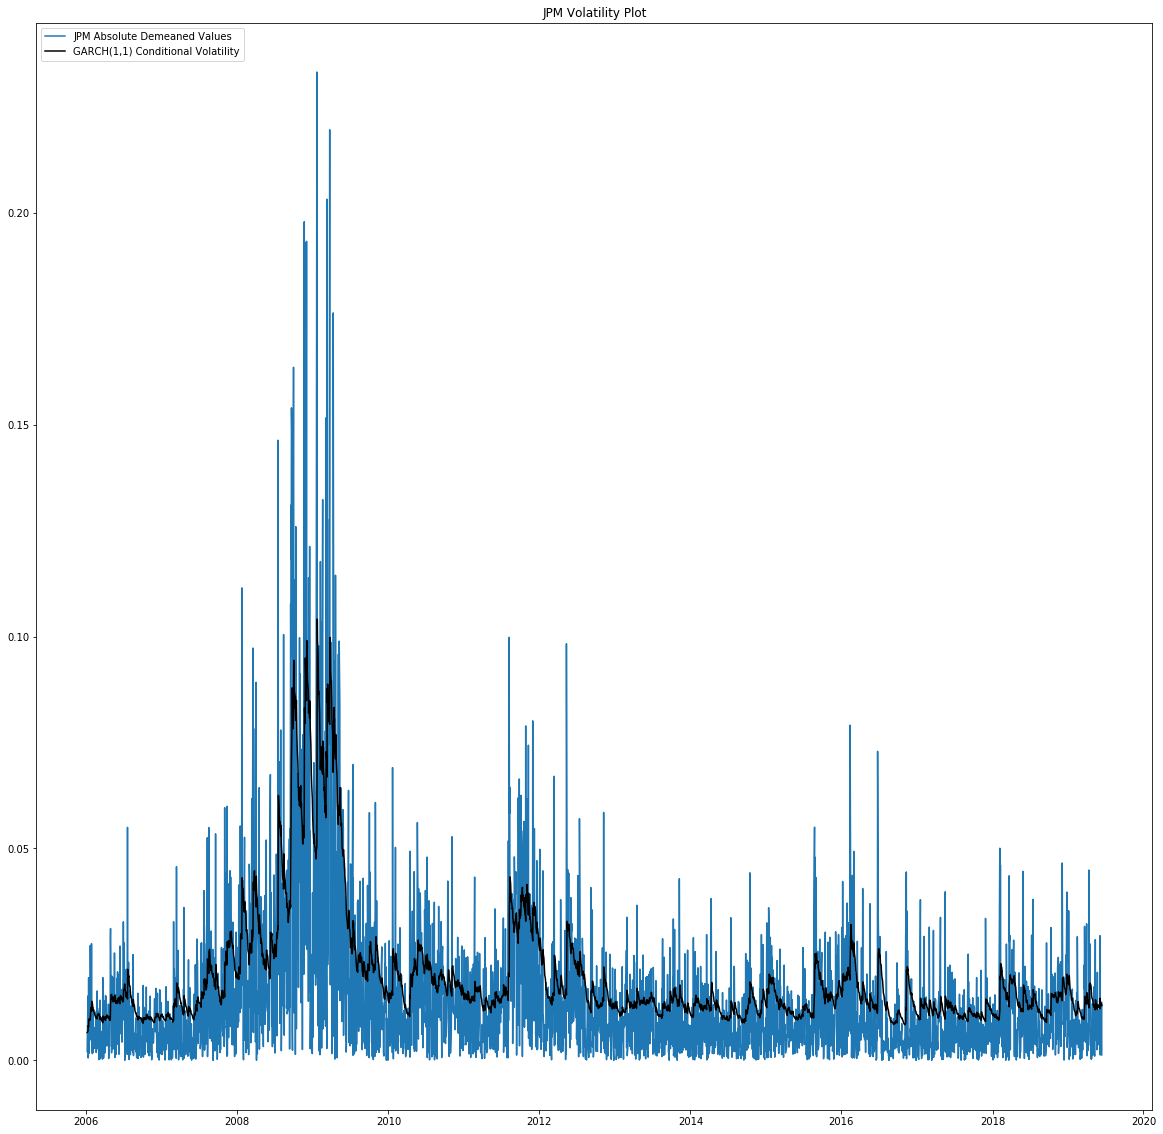

In [8]:
model.plot_fit(figsize=(20, 20))